In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline : 16 octobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

Thomas Gravier, Blandine Gorce

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [ ]:
pip install librosa #utilisee pour comparer le resultat obtenu

In [2]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [15]:
rate, signal = scipy.io.wavfile.read("coloniedefourmies.wav") 
ipd.Audio(signal, rate=rate)
#nous avons utilise le fichier audio du cours car notre enregistrement etait de tres mauvaise qualite (micro cassé)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

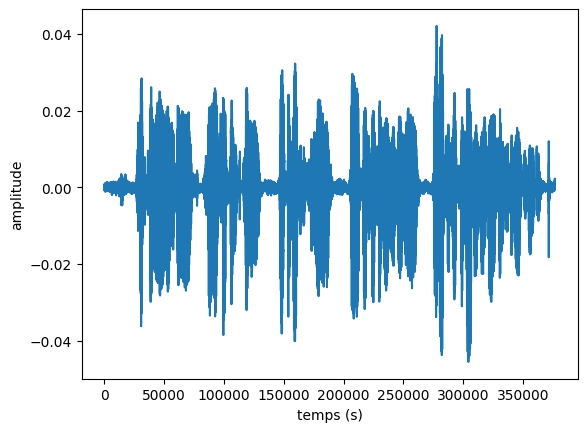

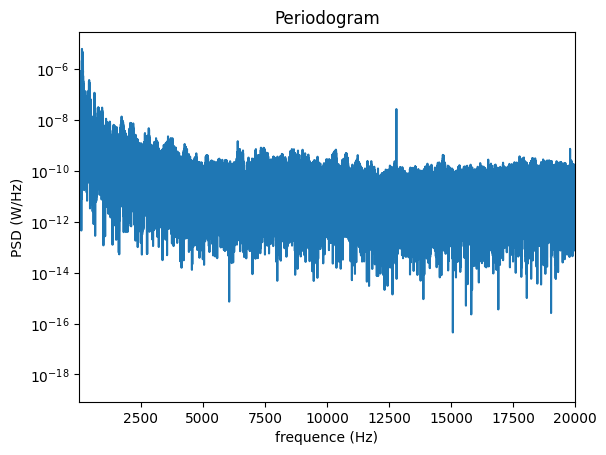

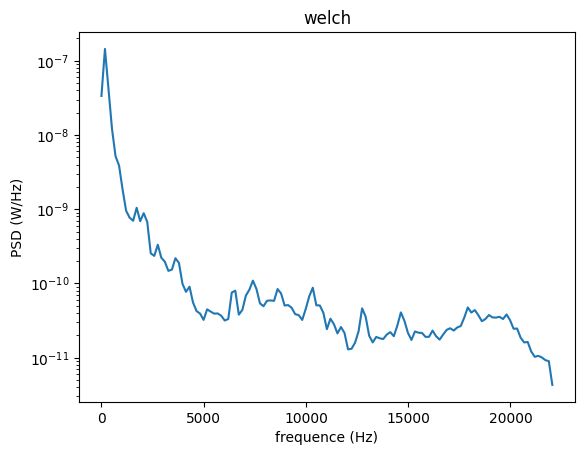

In [16]:
#forme du signal
plt.plot(signal)
plt.xlabel('temps (s)')
plt.ylabel('amplitude')
plt.show()

from scipy.signal import periodogram

f, Pxx = periodogram(signal, fs=rate)  # 'rate' étant la fréquence d'échantillonnage
plt.semilogy(f, Pxx)
plt.xlabel('frequence (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.title('Periodogram')
plt.xlim([1, 20000])  # Pour limiter l'affichage à 20 kHz
plt.show()


#estimation de la densite spectrale de puissance
from scipy.signal import welch
f, psd = welch(signal, fs=rate)
plt.semilogy(f, psd)
plt.xlabel('frequence (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.title('welch')
plt.show()

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

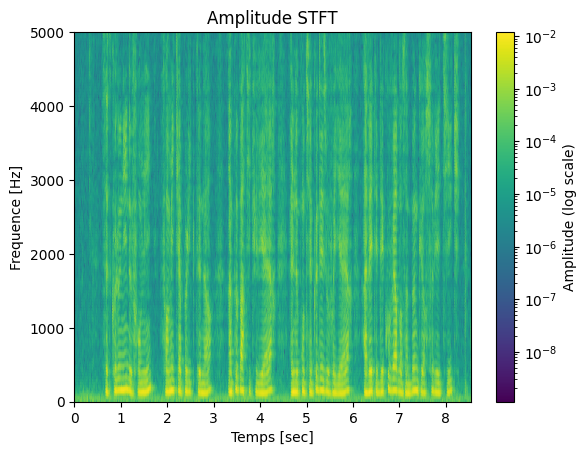

In [17]:
from scipy.signal import stft
import matplotlib.colors as colors

fe = rate  # Fréquence d'échantillonnage
window_size_ms = 25  # Taille de la fenêtre en millisecondes (20-40 ms pour la voix humaine)
nperseg = int(fe * window_size_ms / 1000)  # Calcul du nombre d'échantillons par fenêtre
nfft = nperseg  # Taille de la FFT (peut être augmenté pour une meilleure résolution fréquentielle)

# Calcul de la STFT
freq, time, spectrogram = stft(signal, fs=fe, nperseg=nperseg, nfft=nfft)

# Affichage du spectrogramme avec normalisation logarithmique
plt.pcolormesh(time, freq, np.abs(spectrogram), 
               norm=colors.LogNorm(vmin=np.abs(spectrogram).min(), vmax=np.abs(spectrogram).max()), 
               shading='gouraud')

# Ajout des labels et de la barre de couleur
plt.title('Amplitude STFT')
plt.ylabel('Frequence [Hz]')
plt.xlabel('Temps [sec]')
plt.colorbar(label='Amplitude (log scale)')
plt.ylim([0, 5000])  # Limiter l'affichage à 5 kHz (la voix humaine est principalement sous 5 kHz)
plt.show()

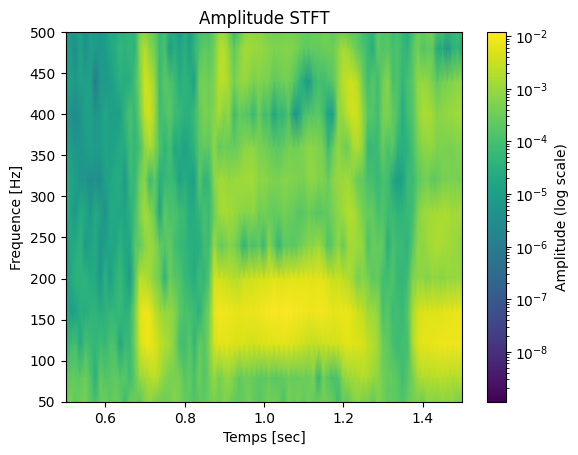

In [19]:
# Affichage du spectrogramme avec normalisation logarithmique en focalisant sur les frquences correspondant a la voix
plt.pcolormesh(time, freq, np.abs(spectrogram), 
               norm=colors.LogNorm(vmin=np.abs(spectrogram).min(), vmax=np.abs(spectrogram).max()), 
               shading='gouraud')

# Ajout des labels et de la barre de couleur
plt.title('Amplitude STFT')
plt.ylabel('Frequence [Hz]')
plt.xlabel('Temps [sec]')
plt.colorbar(label='Amplitude (log scale)')
plt.ylim([50, 500])  # Limiter l'affichage à 5 kHz (la voix humaine est principalement sous 5 kHz)
plt.xlim([0.5, 1.5])
plt.show()

#Commentaire: on peut lire un pitch autour de 150-200Hz

In [20]:
#Les paramètres de la STFT sont ajustés pour analyser la voix humaine. nperseg (25 ms) capture les variations temporelles 
# du signal vocal tout en maintenant une bonne résolution fréquentielle. nfft est fixé à la même valeur pour une correspondance 
# optimale. Une normalisation logarithmique est utilisée pour mieux visualiser la dynamique du signal, et l'affichage est limité 
# à 5000 Hz, car l'essentiel des informations vocales se trouve dans cette bande.

### <div class=consignes> Calcul du Pitch </div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

windows = 0.02 s
trame = 882
nb_iter = 426


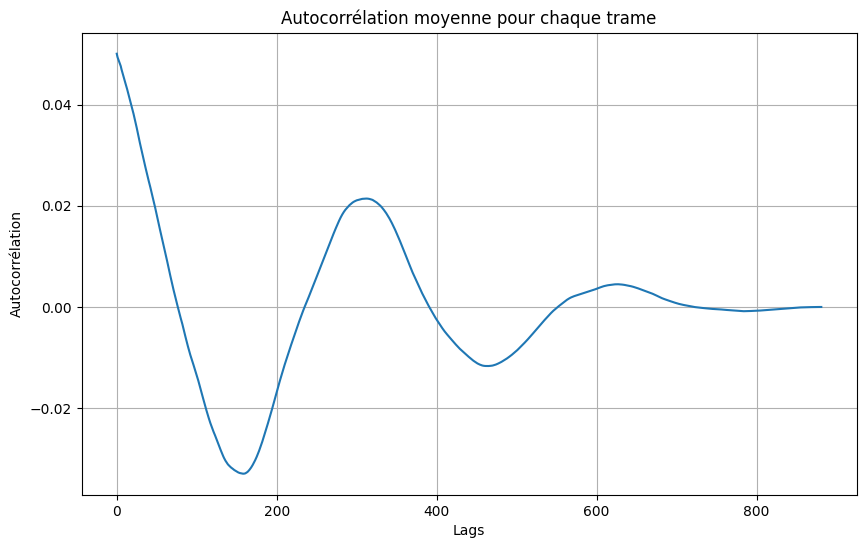

In [21]:
# Paramètres
windows = 20e-3  # Durée de la fenêtre en secondes


# Calcul des paramètres basés sur le signal
trame = int(rate * windows)
nb_iter = len(signal) // trame

print(f"windows = {windows} s")
print(f"trame = {trame}")
print(f"nb_iter = {nb_iter}")

# Calcul de l'autocorrélation pour chaque trame
autocorrelations = []

for i in range(nb_iter):
    trame_signal = signal[i * trame: (i + 1) * trame]
    autocorr = np.correlate(trame_signal, trame_signal, mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Garde seulement la seconde moitié
    autocorrelations.append(autocorr)

# Moyenne des autocorrélations
autocorrelation_moyenne = np.mean(autocorrelations, axis=0)

# Tracé de l'autocorrélation
plt.figure(figsize=(10, 6))
plt.plot(autocorrelation_moyenne)
plt.title('Autocorrélation moyenne pour chaque trame')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation')
plt.grid(True)
plt.show()


In [22]:
#Pour la moyenne on repère un pic à 300 lags, ce qui correspond à 147 Hz, maintenant on va faire la même chose mais en ayant
#  le pic pour chaque autocorrelation. On utilise scipy.signal et on s'inspire de la méthode qui filtre le premier max entre 
# 0 et 300 Hz ce qui correspond aux pics de la voie, on fait ça pour s'affranchir un peu du bruitage du signal.

In [23]:
import numpy as np
from scipy.signal import find_peaks

def find_first_peak_indices(arr_list, rate):
    first_peak_indices = []  # Liste pour stocker l'indice du premier pic filtré de chaque tableau

    # Déterminer la plage d'indices valides correspondant à 60 Hz et 300 Hz
    min_index = rate // 400  # Decalage correspondant à 300 Hz
    max_index = rate // 70    # Decalage correspondant à 60 Hz

    for data in arr_list:
        # Trouver les indices des pics locaux
        peaks, _ = find_peaks(data)

        # Filtrer les pics dont l'indice est compris entre min_index et max_index
        valid_peaks = [peak for peak in peaks if min_index <= peak <= max_index]

        # Vérifier s'il y a au moins un pic valide
        if len(valid_peaks) >= 1:
            # Ajouter l'indice du premier pic valide trouvé
            first_peak_indices.append(rate/valid_peaks[0])
        else:
            # Si aucun pic valide n'est trouvé, ajouter None ou un autre indicateur
            first_peak_indices.append(None)
    
    return first_peak_indices

# Appliquer la fonction à chaque tableau de la liste
pitch = find_first_peak_indices(autocorrelations, rate)

In [24]:
pitch = np.array(pitch)
pitch.mean()
#Commentaire: On repère ici un pic moyen à 232 Hz, je ne pense pas que notre méthode est très resitante au bruit.

np.float64(284.8241519905838)

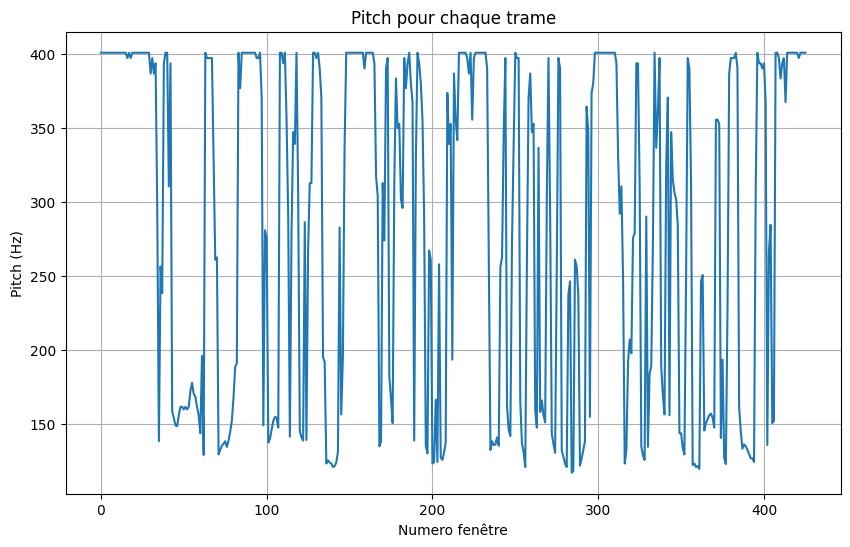

In [25]:
# Tracé de l'autocorrélation
plt.figure(figsize=(10, 6))
plt.plot(pitch)
plt.title('Pitch pour chaque trame')
plt.xlabel('Numero fenêtre')
plt.ylabel('Pitch (Hz)')
plt.grid(True)
plt.show()

In [26]:
#On compare avec librosa pour voir le resultat de l'état de l'art :

!pip install librosa


import librosa

# Charger le signal audio (par exemple, un fichier audio WAV ou un tableau numpy de signal)
rate = 44100  # Exemple de fréquence d'échantillonnage 


# Estimer le pitch avec la méthode P-YIN de librosa
f0, voiced_flag, voiced_probs = librosa.pyin(
    signal, 
    fmin=librosa.note_to_hz('C2'),  # Fréquence minimale (par exemple 65 Hz)
    fmax=librosa.note_to_hz('C7'),  # Fréquence maximale (par exemple 2093 Hz),
    sr=rate,
    frame_length=int(0.02 * rate)  # Longueur de trame de 20 ms
)

# Tracer le pitch estimé
times = librosa.times_like(f0, sr=rate)  # Temps associé à chaque trame

plt.plot(times, f0, label="Pitch (Hz)")
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Pitch contour over time (using librosa.pyin)')
plt.show()

zsh:1: command not found: pip


ModuleNotFoundError: No module named 'librosa'

In [27]:
#On se rend compte que l'estimation est cohérente avec l'ordre de grandeur du pitch de la voix. Nos résultats précédents sont
#  donc peu fiable. Celui avec la moyenne des autocorellations avant de détecter les pics est le plus probant mais on a pas accès 
# au pitch au cours du temps avec celui-ci.

## <div class=consignes> Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [28]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']
print(labels[5])

1.0


## <div class=consignes>  Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

In [29]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    puissance = (1 / 1000) * np.sum(abs(signal * signal))
    return puissance >= seuil

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [30]:
#definition du seuil
seuil = 0.3
n =len(labels)

impulsions = np.zeros(len(labels))
for i in range(len(labels)):
    sample = signaux[i]
    impulsions[i] = contient_impulsion_energie(sample, seuil)

#pourcentage de signaux avec impulsions
print(impulsions.sum()/len(labels))


0.3368


<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [31]:
VP = np.sum(impulsions * labels)
FP = np.sum(impulsions) - VP
VN = np.sum((np.ones(n) - impulsions) * (np.ones(n) - labels))
FN = np.sum(np.ones(n) - impulsions) - VN

print(VP)
print(FP)
print(VN)
print(FN)


2086.0
1282.0
3714.0
2918.0


##  <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


In [32]:
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
    "Cette fonction permet de reperer les impulsions dans le signal grace au spectrogramme"

    #Calcul du spectrogramme sur de courtes fenetres de temps
    freq, time, spectrogram = stft(signal, fs=1000, nperseg=1000, nfft=1000)

    #on somme le resultat sur les lignes pour mettre en avant l'impulsion par rapport au bruit blanc
    sp_sum = np.sum(spectrogram, axis=1)
    return np.max(sp_sum)>= seuil



In [33]:
#definition du seuil
threshold = 0.1

#on detecte les impulsions sur chaque signal grace a la methode precedente
impulsions = np.zeros(len(labels))
for i in range(len(labels)):
    sample = signaux[i]
    impulsions[i] = contient_impulsion_spectrogramme(sample, threshold)

#pourcentage de signaux avec impulsions 
print(impulsions.sum()/len(labels))

0.3489


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 

$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$

et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

In [34]:
#Commentaire:
#La precision VP/(VP+FP) nous permet de connaitre la probabilite a laquelle il y a une impulsion lorsqu'il en detecte une.

#Le rappel VP/(VP+FN) nous permet de connaitre la probabilite de detections correctes d'impulsions. 

#Pour comprendre la preformance d'un algorithme, il est important de calculer les deux, et selon les cas d'usages, 
# on va chercher a optimiser en priorite l'un ou l'autre. Pour une detection de maladie par exemple, on pourra preferer
# un modele qui a une bonne precision quitte a avoir un moins bon rappel.

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

In [35]:
from typing import Callable

def calcul_precision_rappel(signaux: np.ndarray,labels: np.ndarray, seuil: float, methode: Callable[[np.ndarray, float], bool]) -> float :
    "Cette function calcule la precision et le rappel pour la detection des impulsions grace aux deux methodes presentees precedemment"

    impulsions = np.zeros(len(labels))
    n=len(labels)

    #detection des impulsions selon la methode choisie
    for i in range(len(labels)):
        sample = signaux[i]
        impulsions[i] = methode(sample, seuil)
    
    #calcul des metriques d'evaluation
    VP = np.sum(impulsions * labels)
    FP = np.sum(impulsions) - VP
    VN = np.sum((np.ones(n) - impulsions) * (np.ones(n) - labels))
    FN = np.sum(np.ones(n) - impulsions) - VN

    #calcul de la precision et du rappel
    precision = VP/(VP+FP)
    rappel = VP/(VP+FN)

    return precision, rappel


In [71]:
#definition des seuils
seuils = np.array([0.01,0.04,0.07, 0.09, 0.1,0.15,0.2,])
m = len(seuils)


precisions_sp = np.zeros(m)
precisions_en = np.zeros(m)
rappels_sp = np.zeros(m)
rappels_en = np.zeros(m)


for i in range(m):
    precisions_en[i], rappels_en[i] =  calcul_precision_rappel(signaux, labels, seuils[i], contient_impulsion_energie)
    precisions_sp[i], rappels_sp[i]=  calcul_precision_rappel(signaux, labels, seuils[i], contient_impulsion_spectrogramme)
    

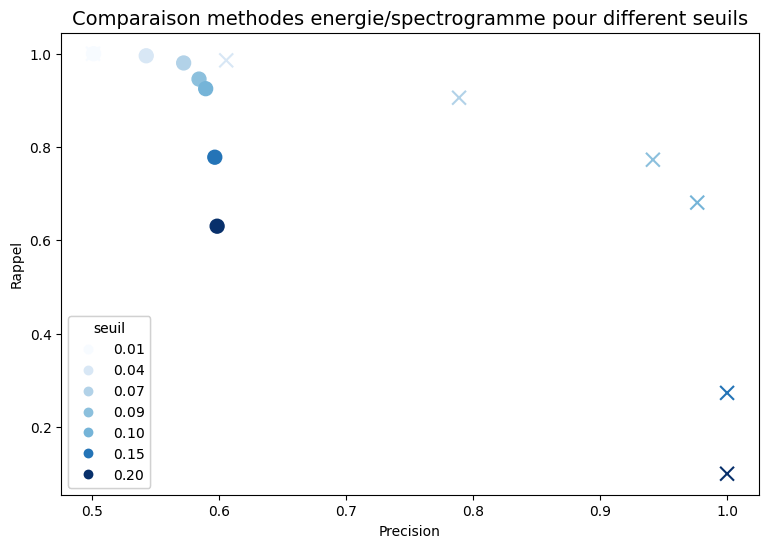

In [72]:
#tracer du rappel en fonction de la precision pour differentes valeures de seuil et pour chaque methode
fig, ax = plt.subplots( figsize = (9,6))
ax.scatter(precisions_sp, rappels_sp, c = seuils , cmap = 'Blues', s=100, marker='x' )
scatter = ax.scatter(precisions_en, rappels_en, c = seuils , cmap = 'Blues', s=100, marker='o' )
legend = ax.legend(*scatter.legend_elements(), loc="lower left",
                   title="seuil")
ax.add_artist(legend)
ax.set_xlabel('Precision')
ax.set_ylabel('Rappel')
ax.set_title('Comparaison methodes energie/spectrogramme pour different seuils', size = 14)
plt.show()

In [40]:
#On voit sur le graph precedent que le rappel en fonction de la precision evoluent differement pour chaque methode. 
# Le rappel decroit assez rapidement des que la precision augmente pour la methode 1 en stagnant autour de 0.5 en precision et en rappel. 
#Au contraire la deuxieme methode augmente fortement la precision sans trop diminuer le rappel, jusqu'a un certain point ou le rappel 
# commence a chuter car on ne detecte que peu de pics. On en deduit que la methode 2 (spectrogramme) avec un seuil a 0.09 donne les 
# meilleurs resultats.